# Metaheuristic Optimization Without Input Multiplication Factors:

This file contains the optimization process using the original MySQL and Excel databases, without any modifications or applied factors.

This archive is using OUR DATASET!

In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene
import build_data
from build_data import ext_pyomo_vals
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

from help_methods import *
# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

## Set Up Varibles - My SQL Database:
#### Performance Notes for Specific Dates
- November 6th runs quickly.
- At the end of November 13th, the forecasts are higher than the actual consumption.
- November 16th/17th is an example of very poor forecasting.

In [2]:
_specific_date = '2019-11-06'  # Change the date
_time_step = 60                 # Change the time interval (in minutes)

## Set Up Variables - Metaheuristic Model:

If you change here, it changes automatically in the entire simulation.

In [3]:
pop_size=20
n_iter=10000 
iter_tolerance=1000
algorithm = 'mgo' #Options are 'hyde_df', 'mgo' and 'do'

## Input Excel Path: 

If you modify the input path here, it will automatically update throughout the entire simulation. ;D

In [4]:
_file_path_excel = 'data/EC_V4_new_UC1.xlsx'

# Method 1 - Forecast Data:

In this method, it is used the data from mysql forecast databases as input for load and generators.

In [5]:
# Data parsing
method_obj_1 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [6]:
method1_folder = f"./input_data/{algorithm}/UC1/method1"

# Define generators
gens1 = Generator(name='gens',
                 value=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_1.data.generator['p_forecast'],
                 cost=method_obj_1.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_1.data.generator['cost_nde'],
                 is_renewable=method_obj_1.data.generator['type_generator'])

method_obj_1.get_data_from_db(specific_date=_specific_date, table="generators_forecast", end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=method1_folder, save=True)


# Define loads
loads1 = Load(name='loads',
             value=method_obj_1.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_1.data.load['p_forecast'].shape),
             upper_bound=method_obj_1.data.load['p_forecast'],
             cost=np.ones(method_obj_1.data.load['p_forecast'].shape),
             cost_cut=method_obj_1.data.load['cost_cut'],
             cost_reduce=method_obj_1.data.load['cost_reduce'],
             cost_ens=method_obj_1.data.load['cost_ens'])


method_obj_1.get_data_from_db(specific_date=_specific_date, table="loads_forecast", end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=method1_folder, save=True)

# Define storage
stor1 = Storage(name='stor',
               value=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_1.data.storage['energy_capacity'] *
                            np.ones(method_obj_1.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_1.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_1.data.storage['discharge_price'],
               cost_charge=method_obj_1.data.storage['charge_price'],
               capacity_max=method_obj_1.data.storage['energy_capacity'],
               capacity_min=method_obj_1.data.storage['energy_min_percentage'],
               initial_charge=method_obj_1.data.storage['initial_state'],
               discharge_efficiency=method_obj_1.data.storage['discharge_efficiency'],
               discharge_max=method_obj_1.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_1.data.storage['charge_efficiency'],
               charge_max=method_obj_1.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor1.to_json(path=method1_folder)

# Define vehicle to grid
v2g1 = Vehicle(name='evs',
              value=np.zeros(method_obj_1.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_1.data.vehicle['e_capacity_max'] * method_obj_1.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_1.data.vehicle['e_capacity_max'] * np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_1.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_1.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_1.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_1.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_1.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_1.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_1.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_1.data.vehicle['schedule_charge'])
v2g1.to_json(path=method1_folder)

# Define imports and exports
pimp1 = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape))
pimp1.to_json(filename="pimp1", path=method1_folder)

pexp1 = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape))
pexp1.to_json(filename="pexp1",path=method1_folder)

# Establish the components
ec_components = {'gen': gens1,
                 'loads': loads1,
                 'stor': stor1,
                 'evs': v2g1,
                 'pimp': pimp1,
                 'pexp': pexp1}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [7]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=method_obj_1.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
scene.initialize()
scene.run(algorithm=algorithm)


The chosen Metaheuristic is hyde_df.



  0%|          | 3/10000 [00:00<22:12,  7.50it/s]

100%|██████████| 10000/10000 [15:10<00:00, 10.98it/s] 


In [8]:
scene.to_json(path=f"./results/{algorithm}/UC1/method_1", filename="scene1_results")

In [9]:
scene.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value,
                              name=f"iterations_{n_iter}_profile_data_1.xlsx", path=f"results/{algorithm}/UC1/method_1"
                              )

In [10]:
scene.current_best['pImp']

array([0.9913899 , 0.04761583, 0.        , 0.29778847, 0.20351592,
       0.4720113 , 4.9249392 , 0.        , 0.        , 0.13458631,
       0.        , 0.02626076, 0.02249659, 0.        , 0.0243547 ,
       0.15220946, 0.        , 0.        , 0.09026901, 0.04922442,
       0.02332845, 0.        , 3.49978853, 0.03854925])

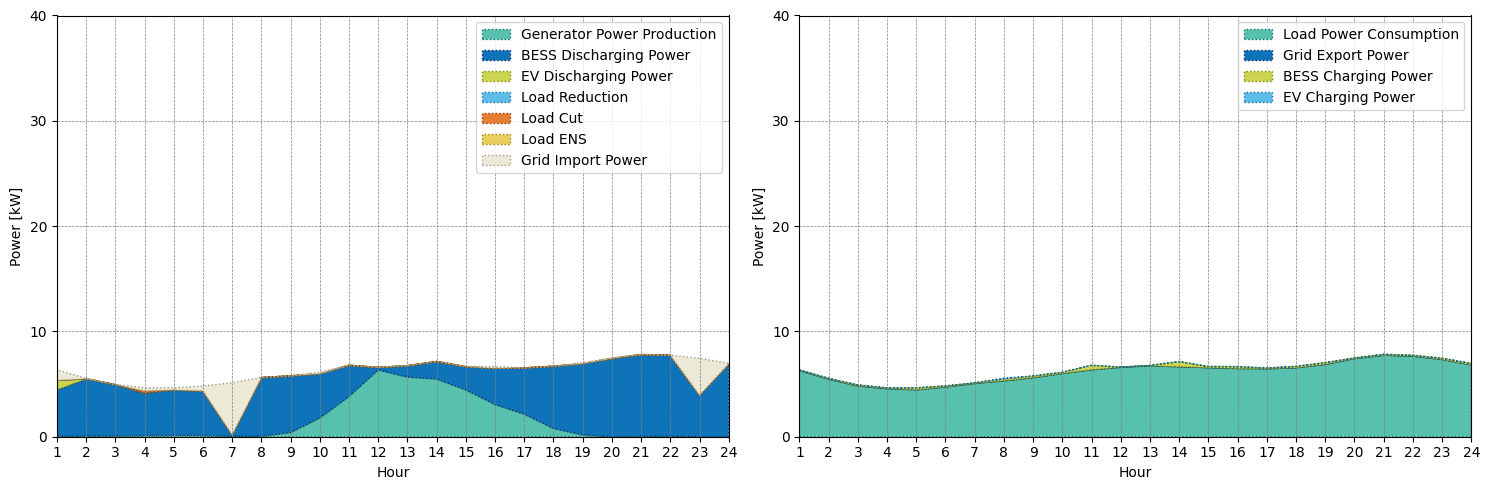

In [11]:
scene.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value, save=True,
                              name=f"iterations_{n_iter}_profile_data_1", path=f"plots/{algorithm}/UC1/method_1", graph_max=40, graph_step=10)

In [12]:
#scene.components['evs'].capital_cost
v2g1.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [13]:
# Sum matrices along the columns

scene.algo.population_fitness

[8.94389675102683,
 8.896136292295893,
 8.957660672556795,
 8.960642036033661,
 9.00869138126548,
 8.93956059468476,
 8.969287521536295,
 8.957650708041855,
 8.899997923633782,
 8.9453879499537,
 8.929008126012079,
 8.943703966402639,
 8.909917323667578,
 8.992122867716375,
 8.955446210066734,
 8.921201794547445,
 8.94027291192405,
 8.952560470319856,
 8.961288126643758,
 8.891506496609027]

In [14]:
 # Check the population

scene.algo.population

array([[0.01345636, 0.01104861, 0.00176259, ..., 1.        , 0.        ,
        0.        ],
       [0.01368338, 0.01052349, 0.0017724 , ..., 1.        , 0.        ,
        0.        ],
       [0.01326602, 0.01091345, 0.00180104, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.01408358, 0.01101115, 0.00179681, ..., 1.        , 0.        ,
        0.        ],
       [0.01350035, 0.01115567, 0.00178501, ..., 1.        , 0.        ,
        0.        ],
       [0.01349049, 0.01097556, 0.00175811, ..., 1.        , 0.        ,
        0.        ]])

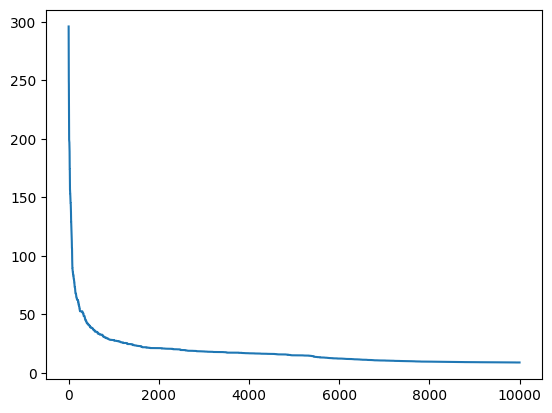

In [15]:
plt.plot(scene.algo.population_history_fitness)

In [16]:
scene.algo.population_history_fitness

[295.962174467103,
 273.08764470361274,
 269.4346528816935,
 251.28809409730462,
 249.1305049970394,
 246.7689055454659,
 235.87703443896808,
 215.2099885936575,
 215.2099885936575,
 215.2099885936575,
 204.29685153743762,
 199.02008302068015,
 198.55847904666308,
 198.15637597778837,
 198.15637597778837,
 198.15637597778837,
 196.93461827627084,
 194.3761237953704,
 191.73023219447313,
 191.73023219447313,
 191.67282670881931,
 188.85461468974222,
 173.94016717756895,
 173.94016717756895,
 173.94016717756895,
 173.94016717756895,
 172.9932834506263,
 165.27608311949376,
 160.98959404009355,
 160.9620161449998,
 156.32236945462373,
 156.32236945462373,
 153.38417812522354,
 153.38417812522354,
 153.38417812522354,
 153.38417812522354,
 152.58921838221886,
 152.58921838221886,
 151.20511046485674,
 148.62507501563982,
 148.62507501563982,
 145.23404517454458,
 145.23404517454458,
 145.23404517454458,
 145.23404517454458,
 145.23404517454458,
 145.23404517454458,
 144.21455719364369,
 14

In [17]:
scene.algo.population_fitness

[8.94389675102683,
 8.896136292295893,
 8.957660672556795,
 8.960642036033661,
 9.00869138126548,
 8.93956059468476,
 8.969287521536295,
 8.957650708041855,
 8.899997923633782,
 8.9453879499537,
 8.929008126012079,
 8.943703966402639,
 8.909917323667578,
 8.992122867716375,
 8.955446210066734,
 8.921201794547445,
 8.94027291192405,
 8.952560470319856,
 8.961288126643758,
 8.891506496609027]

In [18]:
scene.current_best_fitness

8.906462922117873

# Method 2 - Real Data

In [19]:
# Data parsing
method_obj_2 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [20]:
method_obj_2.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [21]:
method2_folder = f"./input_data/{algorithm}/UC1/method2"

# Define generators
gens2 = Generator(name='gens2',
                 value=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_2.data.generator['p_forecast'],
                 cost=method_obj_2.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_2.data.generator['cost_nde'],
                 is_renewable=method_obj_2.data.generator['type_generator'])

method_obj_2.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method2_folder, save=True)


# Define loads
loads2 = Load(name='loads2',
             value=method_obj_2.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_2.data.load['p_forecast'].shape),
             upper_bound=method_obj_2.data.load['p_forecast'],
             cost=np.ones(method_obj_2.data.load['p_forecast'].shape),
             cost_cut=method_obj_2.data.load['cost_cut'],
             cost_reduce=method_obj_2.data.load['cost_reduce'],
             cost_ens=method_obj_2.data.load['cost_ens'])


method_obj_2.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor2 = Storage(name='stor2',
               value=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_2.data.storage['energy_capacity'] *
                            np.ones(method_obj_2.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_2.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_2.data.storage['discharge_price'],
               cost_charge=method_obj_2.data.storage['charge_price'],
               capacity_max=method_obj_2.data.storage['energy_capacity'],
               capacity_min=method_obj_2.data.storage['energy_min_percentage'],
               initial_charge=method_obj_2.data.storage['initial_state'],
               discharge_efficiency=method_obj_2.data.storage['discharge_efficiency'],
               discharge_max=method_obj_2.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_2.data.storage['charge_efficiency'],
               charge_max=method_obj_2.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor2.to_json(path=method2_folder)

# Define vehicle to grid
v2g2 = Vehicle(name='evs2',
              value=np.zeros(method_obj_2.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_2.data.vehicle['e_capacity_max'] * method_obj_2.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_2.data.vehicle['e_capacity_max'] * np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_2.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_2.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_2.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_2.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_2.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_2.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_2.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_2.data.vehicle['schedule_charge'])
v2g2.to_json(path=method2_folder)

# Define imports and exports
pimp2 = BinaryResource(name='pImp2',
                      value=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape))
pimp2.to_json(filename="pimp2",path=method2_folder)

pexp2 = BinaryResource(name='pExp2',
                      value=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape))
pexp2.to_json(filename="pexp2",path=method2_folder)

# Establish the components
ec_components = {'gen': gens2,
                 'loads': loads2,
                 'stor': stor2,
                 'evs': v2g2,
                 'pimp': pimp2,
                 'pexp': pexp2}

ec_components

{'gen': gens2,
 'loads': loads2,
 'stor': stor2,
 'evs': evs2,
 'pimp': pImp2,
 'pexp': pExp2}

In [22]:
# Create the scene

scene2 = HMProblemScene(name='EC2', data=ec_components, hm_parser=method_obj_2.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
scene2.initialize()
scene2.run(algorithm=algorithm)


The chosen Metaheuristic is hyde_df.



 30%|██▉       | 2999/10000 [04:05<09:32, 12.23it/s]


KeyboardInterrupt: 

In [ ]:
scene2.to_json(path=f"./results/{algorithm}/UC1/method_2", filename="scene2_results")

In [ ]:
scene2.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [ ]:
scene2.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name=f"iterations_{n_iter}_profile_data_2.xlsx", path=f"results/{algorithm}/UC1/method_2"
                              )

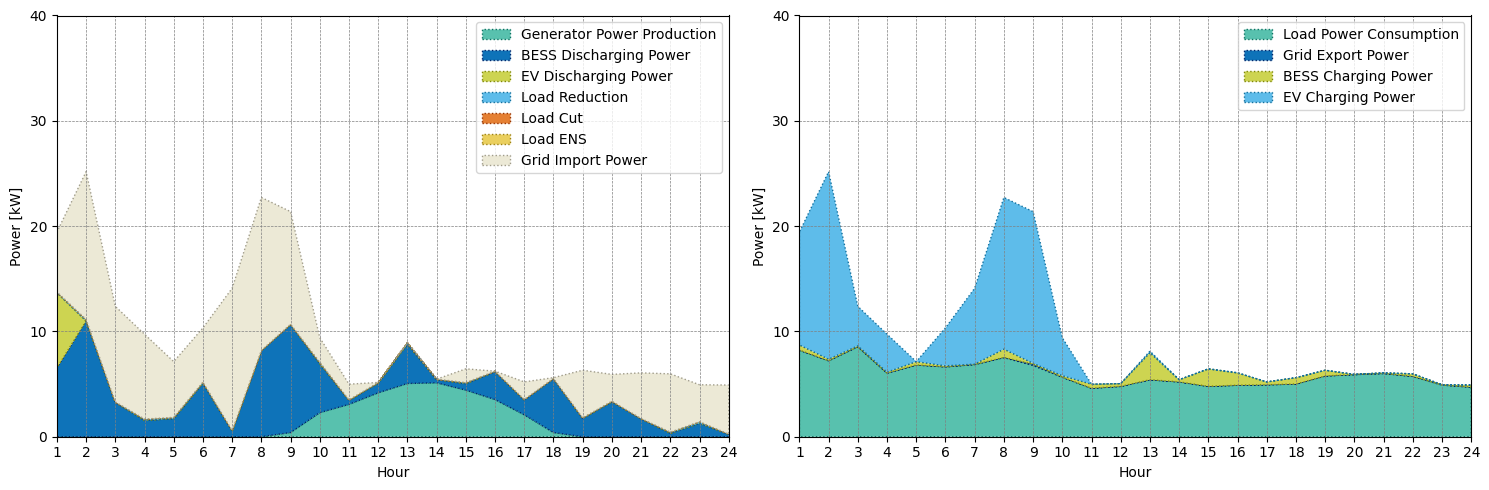

In [ ]:
scene2.plot(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value, save=True,
                              name=f"iterations_{n_iter}_profile_data_2", path=f"plots/{algorithm}/UC1/method_2", graph_max=40, graph_step=10)

In [ ]:
#scene.components['evs'].capital_cost
v2g2.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [ ]:
# Sum matrices along the columns

scene2.algo.population_fitness

[19.127571443150195,
 19.127571443150252,
 19.127571443150252,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150273,
 19.127571443150273]

In [ ]:
 # Check the population

scene2.algo.population

array([[8.751976841111629e-12, 2.239816593449386e-10,
        2.562042609820321e-10, ..., 1, 1, 1],
       [8.75197684111444e-12, 2.239816593449385e-10,
        2.5620426098202997e-10, ..., 1, 1, 1],
       [8.751976841112081e-12, 2.239816593449394e-10,
        2.5620426098203023e-10, ..., 1, 1, 1],
       ...,
       [8.751976841112191e-12, 2.2398165934493888e-10,
        2.562042609820304e-10, ..., 1, 1, 1],
       [8.751976841112761e-12, 2.2398165934493883e-10,
        2.562042609820304e-10, ..., 1, 1, 1],
       [8.751976841112225e-12, 2.2398165934494527e-10,
        2.562042609820304e-10, ..., 1, 1, 1]], dtype=object)

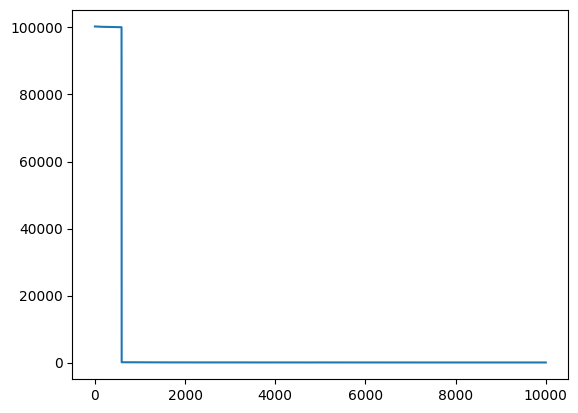

In [ ]:
plt.plot(scene2.algo.population_history_fitness)

In [ ]:
scene2.algo.population_history_fitness

[100297.74116245813,
 100297.69660055105,
 100297.61104620635,
 100297.63429660334,
 100297.39686464598,
 100297.40341273011,
 100297.12559830945,
 100297.14919457372,
 100297.11127445575,
 100297.00608572805,
 100296.83521462743,
 100296.8053721553,
 100296.27980256997,
 100296.19403871147,
 100291.57308598602,
 100291.49585167656,
 100290.97913860566,
 100290.93844198562,
 100290.85971920521,
 100290.79045518002,
 100290.66590571549,
 100290.66978842492,
 100290.6327465243,
 100290.54970080621,
 100290.14520660976,
 100289.76564244999,
 100289.71974223813,
 100288.95052490079,
 100288.72969859114,
 100288.10875753834,
 100282.22941160489,
 100281.3369854384,
 100281.18612708127,
 100280.96775160317,
 100280.87543796218,
 100280.86387787554,
 100280.79460700224,
 100279.23841180318,
 100279.08360011938,
 100277.51487198759,
 100276.54760827743,
 100276.47833109813,
 100276.23719182238,
 100276.21294723697,
 100276.1354779763,
 100275.3104395072,
 100275.0863467891,
 100274.95964568059

In [ ]:
scene2.algo.population_fitness

[19.127571443150195,
 19.127571443150252,
 19.127571443150252,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150263,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150266,
 19.127571443150273,
 19.127571443150273]

In [ ]:
scene2.current_best_fitness

19.127571443150195

# Method 3 - Forecast + Real Data

In [ ]:
# Data parsing
method_obj_3 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [ ]:
method_obj_3.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

## OBS: Preciso validar isso aqui, se o método 3 está igual ao original

In [ ]:
all_data = []
all_models = []
results_dict = {}


integral_of_error_gen = np.zeros((5, 1))
integral_of_error_load = np.zeros((5, 1))

# True - Forecast - Based on Deterministic PYECOM Model (pyecomWforecats.ipynb):
forecast_error_load_at_time = method_obj_2.data.load['p_forecast'][:, :] - method_obj_1.get_data().load['p_forecast'][:, :] 
forecast_error_gen_at_time = method_obj_2.data.generator['p_forecast'][:, :] - method_obj_1.get_data().generator['p_forecast'][:, :]

for i in range(1, 24*60//_time_step+1):
    
    print(i)
    #  Result extraction - Saving the results on CSVs:
    results_folder = f'./results/{algorithm}/UC1/method_3/{i}_step'
    method3_folder = f"./input_data/{algorithm}/UC1/method_3/{i}_step"

    # Define generators
    gens3 = Generator(name='gens3',
                    value=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    lower_bound=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    upper_bound=method_obj_3.data.generator['p_forecast'],
                    cost=method_obj_3.data.generator['cost_parameter_b'],
                    cost_nde=method_obj_3.data.generator['cost_nde'],
                    is_renewable=method_obj_3.data.generator['type_generator'])

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators_forecast", 
                                  experiment_id = 17, start=i, end = 24*60//_time_step, 
                                  time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators", start=0, end = i, 
                                  time_step=_time_step, folder=method3_folder, save=True)
    
    # Define loads
    loads3 = Load(name='loads3',
                value=method_obj_3.data.load['p_forecast'],
                lower_bound=np.zeros(method_obj_3.data.load['p_forecast'].shape),
                upper_bound=method_obj_3.data.load['p_forecast'],
                cost=np.ones(method_obj_3.data.load['p_forecast'].shape),
                cost_cut=method_obj_3.data.load['cost_cut'],
                cost_reduce=method_obj_3.data.load['cost_reduce'],
                cost_ens=method_obj_3.data.load['cost_ens'])


    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads_forecast", experiment_id = 23, 
                                  start=i, end = 24*60//_time_step, time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads",start=0, end = i, 
                                  time_step=_time_step, folder=method3_folder, save=True)

    # Define storage
    stor3 = Storage(name='stor3',
                value=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                lower_bound=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                upper_bound=(method_obj_3.data.storage['energy_capacity'] *
                                np.ones(method_obj_3.data.storage['p_charge_limit'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.storage['p_charge_limit'].shape),
                cost_discharge=method_obj_3.data.storage['discharge_price'],
                cost_charge=method_obj_3.data.storage['charge_price'],
                capacity_max=method_obj_3.data.storage['energy_capacity'],
                capacity_min=method_obj_3.data.storage['energy_min_percentage'],
                initial_charge=method_obj_3.data.storage['initial_state'],
                discharge_efficiency=method_obj_3.data.storage['discharge_efficiency'],
                discharge_max=method_obj_3.data.storage['p_discharge_limit'],
                charge_efficiency=method_obj_3.data.storage['charge_efficiency'],
                charge_max=method_obj_3.data.storage['p_charge_limit'],
                #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
                #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
                capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
    stor3.to_json(filename=f"stor_0-{i}",path=method3_folder)

    # Define vehicle to grid
    v2g3 = Vehicle(name='evs3',
                value=np.zeros(method_obj_3.data.vehicle['schedule_charge'].shape),
                lower_bound=(method_obj_3.data.vehicle['e_capacity_max'] * method_obj_3.data.vehicle['min_technical_soc'] *
                            np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                upper_bound=(method_obj_3.data.vehicle['e_capacity_max'] * np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape),
                cost_discharge=method_obj_3.data.vehicle['discharge_price'][:, 0],
                cost_charge=method_obj_3.data.vehicle['charge_price'][:, 0],
                capacity_max=method_obj_3.data.vehicle['e_capacity_max'],
                initial_charge=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape) * 0.8,
                min_charge=method_obj_3.data.vehicle['min_technical_soc'],
                discharge_efficiency=method_obj_3.data.vehicle['discharge_efficiency'],
                charge_efficiency=method_obj_3.data.vehicle['charge_efficiency'],
                #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
                #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
                capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
                schedule_discharge=method_obj_3.data.vehicle['schedule_discharge'],
                schedule_charge=method_obj_3.data.vehicle['schedule_charge'])
    v2g3.to_json(filename=f"v2g_0-{i}",path=method3_folder)

    # Define imports and exports
    pimp3 = BinaryResource(name='pImp3',
                        value=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['import_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['buy_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape))
    pimp3.to_json(filename=f"pimp_0-{i}",path=method3_folder)

    pexp3 = BinaryResource(name='pExp3',
                        value=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['export_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['sell_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape))
    pexp3.to_json(filename=f"pexp_0-{i}",path=method3_folder)

    # Establish the components
    ec_components = {'gen': gens3,
                    'loads': loads3,
                    'stor': stor3,
                    'evs': v2g3,
                    'pimp': pimp3,
                    'pexp': pexp3}

    ec_components
    
    # Create the scene
    scene3 = HMProblemScene(name='EC3', data=ec_components, hm_parser=method_obj_3.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
    scene3.initialize()
    scene3.run(algorithm=algorithm)

    # Store results in a dictionary

    results_dict = store_results(i, results_dict, 
                    scene3.current_best['pImp'], scene3.current_best['pExp'], scene3.current_best['genActPower'], 
                    scene3.current_best['genExcActPower'], scene3.current_best['genXo'], scene3.current_best['loadRedActPower'], 
                    scene3.current_best['loadCutActPower'], scene3.current_best['loadENS'], scene3.current_best['loadXo'], 
                    scene3.current_best['storEnerState'], scene3.current_best['storDchActPower'], scene3.current_best['storChActPower'], 
                    scene3.current_best['storDchXo'], scene3.current_best['storChXo'], scene3.current_best['v2gChActPower'], 
                    scene3.current_best['v2gDchActPower'], scene3.current_best['v2gEnerState'],
                    scene3.current_best['v2gDchXo'], 
                    scene3.current_best['v2gChXo']
                    )
    scene3.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name=f"step_{i}_n_iter_{n_iter}_profile_data_3.xlsx", path=results_folder
                              )
    

1

The chosen Metaheuristic is do.



 94%|█████████▍| 9419/10000 [37:36<02:19,  4.17it/s] 


KeyboardInterrupt: 

In [ ]:
#Plot the operation of the community results

result_genActPower = np.array([results_dict[hour]['genActPowerInit'] for hour in sorted(results_dict.keys())])
result_storDchActPower = np.array([results_dict[hour]['storDischargeInit'] for hour in sorted(results_dict.keys())])
result_v2gDchActPower = np.array([results_dict[hour]['v2gDischargeInit'] for hour in sorted(results_dict.keys())])
result_loadRedActPower = np.array([results_dict[hour]['loadRedActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadCutActPower = np.array([results_dict[hour]['loadCutActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadENS = np.array([results_dict[hour]['loadENSInit'] for hour in sorted(results_dict.keys())])
result_pimp = np.array([results_dict[hour]['importsInit'] for hour in sorted(results_dict.keys())])
result_genExcActPower = np.array([results_dict[hour]['genExcPowerInit'] for hour in sorted(results_dict.keys())])
result_storChActPower = np.array([results_dict[hour]['storChargeInit'] for hour in sorted(results_dict.keys())])
result_v2gChActPower = np.array([results_dict[hour]['v2gChargeInit'] for hour in sorted(results_dict.keys())])



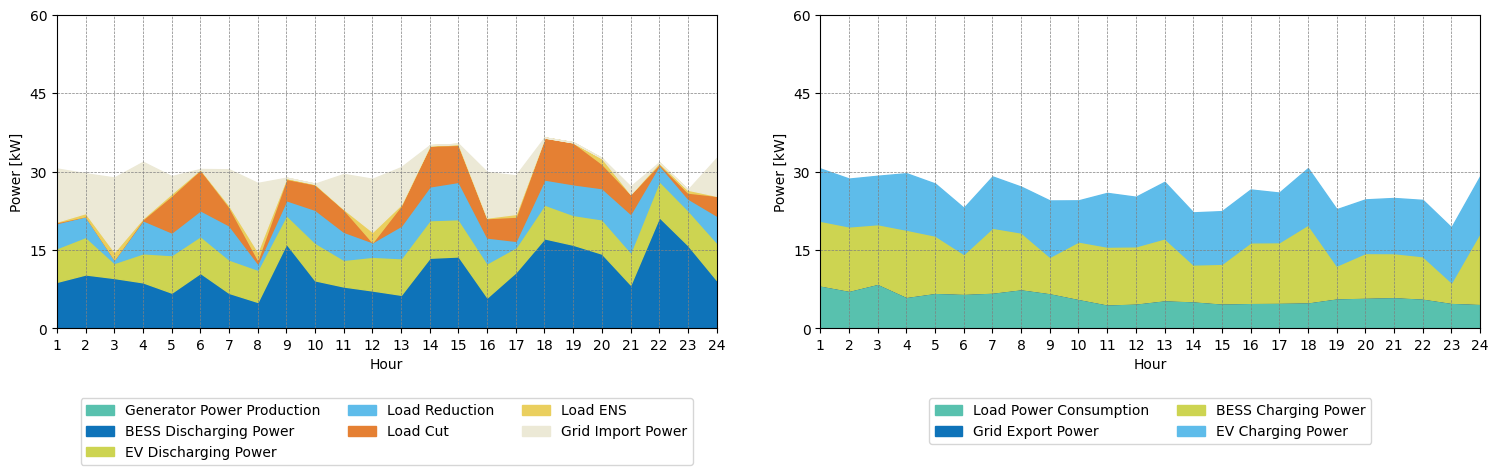

In [ ]:
plot_mixed_results(result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    save = True,
    path = f'plots/{algorithm}/UC1/method_3',
    name =  f'iterations_{n_iter}_profile_data_3.png',
    graph_max = 60,
    graph_step = 15)

In [ ]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
export_mixed_results(
    result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    path=f'./results/{algorithm}/UC1/method_3',  
    name=f"iterations_{n_iter}_profile_data_3.xlsx"   
)